In [1]:
import os, sys
sys.path.append(os.path.abspath('../..'))
import copy
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import floris.tools as wfct

In [2]:
# Define some helper functions
def power_cross_sweep(fi_in, D, dist_downstream, yaw_angle=0):
    fi = copy.deepcopy(fi_in)

    sweep_locations = np.arange(-2, 2.25, 0.25)
    sweep_locations = np.arange(-1, 1.25, 0.25)
    power_out = np.zeros_like(sweep_locations)

    for y_idx, y_loc in enumerate(sweep_locations):

        fi.reinitialize_flow_field(
            layout_array=(
                [0, dist_downstream * D, dist_downstream * D * 2],
                [0, 0, y_loc * D],
            )
        )
        fi.calculate_wake([yaw_angle, 0, 0])
        power_out[y_idx] = fi.get_turbine_power()[2] / 1000.0

    return sweep_locations, power_out


def power_cross_sweep_gain(fi_in, D, dist_downstream, yaw_angle=0):
    fi = copy.deepcopy(fi_in)

    sweep_locations = np.arange(-2, 2.25, 0.25)
    sweep_locations = np.arange(-1, 1.25, 0.25)
    power_out = np.zeros_like(sweep_locations)

    for y_idx, y_loc in enumerate(sweep_locations):

        fi.reinitialize_flow_field(
            layout_array=(
                [0, dist_downstream * D, dist_downstream * D * 2],
                [0, 0, y_loc * D],
            )
        )
        fi.calculate_wake([0, 0, 0])
        base_power = fi.get_turbine_power()[2] / 1000.0
        fi.calculate_wake([yaw_angle, 0, 0])
        power_out[y_idx] = (
            100 * (fi.get_turbine_power()[2] / 1000.0 - base_power) / base_power
        )

    return sweep_locations, power_out

['/home/forest/projects/floris/wfoc/demo', '/home/forest/.vscode-server/extensions/ms-toolsai.jupyter-2021.8.1013163132/pythonFiles', '/home/forest/.vscode-server/extensions/ms-toolsai.jupyter-2021.8.1013163132/pythonFiles/lib/python', '/home/forest/anaconda3/envs/ml/lib/python38.zip', '/home/forest/anaconda3/envs/ml/lib/python3.8', '/home/forest/anaconda3/envs/ml/lib/python3.8/lib-dynload', '', '/home/forest/anaconda3/envs/ml/lib/python3.8/site-packages', '/home/forest/projects/floris', '/home/forest/anaconda3/envs/ml/lib/python3.8/site-packages/IPython/extensions', '/home/forest/.ipython', '/home/forest/projects/floris']


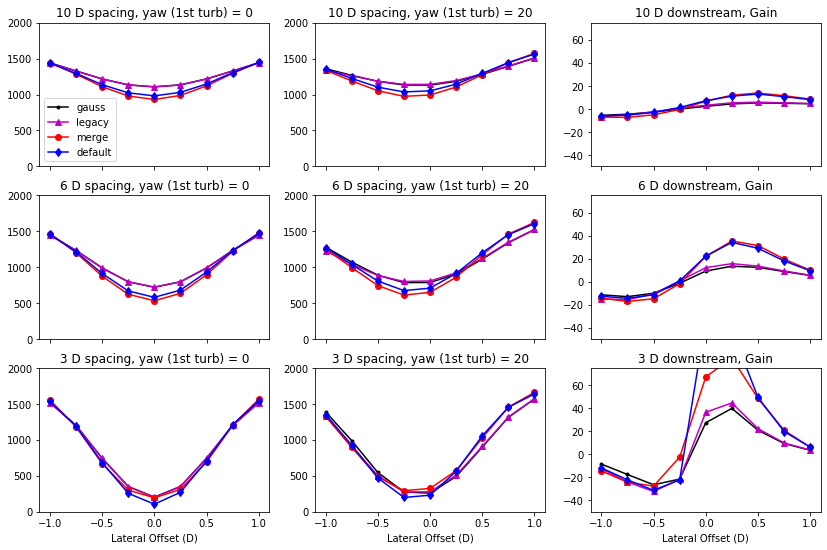

In [9]:
print(sys.path)
# Load the saved FLORIS interfaces
fi_dict = pickle.load(open("../../examples/compare_models/floris_models.p", "rb"))

# Make a plot of comparisons
fig, axarr = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(14, 9))

# Do the absolutes
for d_idx, dist_downstream in enumerate([10, 6, 3]):
    for y_idx, yaw in enumerate([0, 20]):
        ax = axarr[d_idx, y_idx]
        ax.set_title("%d D spacing, yaw (1st turb) = %d" % (dist_downstream, yaw))

        for floris_label in fi_dict:
            (fi, floris_color, floris_marker) = fi_dict[floris_label]

            HH = fi.floris.farm.flow_field.turbine_map.turbines[0].hub_height
            D = fi.floris.farm.turbines[0].rotor_diameter

            sweep_locations, ps = power_cross_sweep(fi, D, dist_downstream, yaw)
            ax.plot(
                sweep_locations,
                ps,
                color=floris_color,
                marker=floris_marker,
                label=floris_label,
            )
            ax.set_ylim([0, 2000])

# Check the gains
for d_idx, dist_downstream in enumerate([10, 6, 3]):
    ax = axarr[d_idx, -1]
    ax.set_title("%d D downstream, Gain" % (dist_downstream))

    for floris_label in fi_dict:
        (fi, floris_color, floris_marker) = fi_dict[floris_label]
        sweep_locations, ps = power_cross_sweep_gain(
            fi, D, dist_downstream, yaw_angle=20
        )
        ax.plot(
            sweep_locations,
            ps,
            color=floris_color,
            marker=floris_marker,
            label=floris_label,
        )
        ax.set_ylim([-50, 75])

axarr[0, 0].legend()
axarr[-1, 0].set_xlabel("Lateral Offset (D)")
axarr[-1, 1].set_xlabel("Lateral Offset (D)")
axarr[-1, 2].set_xlabel("Lateral Offset (D)")
plt.show()